In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import seaborn as sns

from scipy.stats import pearsonr

sns.set_style("darkgrid")
np.random.seed(930525)
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', 200)

warnings.simplefilter('once')

%matplotlib inline
%load_ext watermark
%watermark --iversions

pandas  1.0.4
numpy   1.18.4
seaborn 0.10.1



In [6]:
from statsmodels.formula.api import logit
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.diagnostic import normal_ad
import numpy as np
from scipy import stats
from scipy.stats import chi2_contingency
from scipy.stats import anderson, ttest_ind, mannwhitneyu
import shap
import patsy
from sklearn.metrics import roc_auc_score

import os
import math

/home/bhillmann/.conda/envs/type_1/lib/python3.8/site-packages/patsy/constraint.py:13: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.9 it will stop working
  from collections import Mapping
<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject


In [7]:
df_metadata = pd.read_csv(metadata_file)

In [9]:
df_metadata.columns

Index(['sample_id', 'Sample_Number', 'Sample_Code', 'Shotgun', '16s',
       'viral_load', 'nCoVN1', 'nCoVN2', 'RNase P', 'ConcN1', 'ConcN2', 'N1',
       'Sex', 'Age', 'Age_range', 'Age_average', 'Blood_sampling_date',
       'Swab date', 'Severe_Case', 'REUMA', 'PNEUMO', 'ONCO', 'HEMATO',
       'DIABETES', 'METABOLIC', 'CARDIO', 'HYPERTENSION', 'NEPHRO', 'TB',
       'HIV', 'IMMUNOSUPPRESSION', 'HEPATOPATHY', 'HCQ', 'LPV', 'HCQ_LPV',
       'HCQ_LPV_01', 'HCQ_LPV_02', 'RDV', 'TCZ', 'BCT', 'Steroide',
       'SYMPTOMS_ONSET', 'SYMPTOMS_TO_SWAB_DAYS', 'Swab_day_quartile',
       'Set_severe', 'swab_days_avg', 'SD_q1_severe', 'SD_q1_HB02', 'swab_out',
       'OUTCOME', 'Hospitalization_Days', 'CRP', 'CRP_range', 'LDH',
       'LDH_range', 'Ferritin', 'CPK', 'CPK_range', 'WBC', 'WBC_range',
       'Neutrophil_Count', 'AST', 'ALT', 'Albumin', 'D.Dimer', 'Lowest_SpO2',
       'Hospital_bin', 'Hospital_bin_01', 'Hospital_bin_02', 'q1', 'bin_02',
       'HCQ.1', 'LPV.1', 'HB_02_HCQ', 'HB_02

In [15]:
df = df_metadata.copy()

In [42]:
continous_variables = ['Age', 'SYMPTOMS_TO_SWAB_DAYS', 'Hospitalization_Days',
                       'CRP', 'LDH', 'Ferritin', 'CPK', 'WBC',
       'Neutrophil_Count', 'AST', 'ALT', 'Albumin', 'D.Dimer', 'Lowest_SpO2']
binary_variables = ['viral_load', 'Sex', 'Severe_Case', 'REUMA', 'PNEUMO', 'ONCO', 'HEMATO',
       'DIABETES', 'METABOLIC', 'CARDIO', 'HYPERTENSION', 'NEPHRO', 'TB',
       'HIV', 'IMMUNOSUPPRESSION', 'HEPATOPATHY', 'HCQ', 'LPV', 'RDV', 'TCZ', 'BCT', 'Steroide']
categorical_variables = ['']

response = 'OUTCOME'

figure_dir = 'results'

In [26]:
def get_fig_size(fig_width_in, fig_height_in=None):
    """Convert dimensions in centimeters to inches.
    If no height is given, it is computed using the golden ratio.
    """
    if not fig_height_in:
        golden_ratio = (1 + math.sqrt(5))/2
        fig_height_in = fig_width_in / golden_ratio

    return fig_width_in, fig_height_in

def save_plot(fig, pltname, artists=(), size_inches=get_fig_size(4), basepath=figure_dir):
    fig.set_size_inches(size_inches)
    fig.savefig(os.path.join(basepath, pltname + ".png"), dpi=350, bbox_extra_artists=artists, bbox_inches='tight', transparent=False)
#     fig.savefig(os.path.join(basepath, pltname + ".eps"), dpi=350, bbox_extra_artists=artists, bbox_inches='tight', transparent=False)
    
def custom_legend(fig, colors, labels, legend_location="center left", legend_boundary = (1,.5), marker="o"):
    # Create custom legend for colors"
    patches = [ plt.plot([],[], marker=marker, ms=10, ls="", mec=None, color=colors[i], label="{:s}".format(labels[i]) )[0]  for i in range(len(labels)) ]
    artist = fig.legend(patches, labels, loc=legend_location, bbox_to_anchor=legend_boundary, fontsize=8)
    return artist

In [33]:
df_metadata["OUTCOME"].value_counts()

Discharged    75
Deceased      25
Name: OUTCOME, dtype: int64

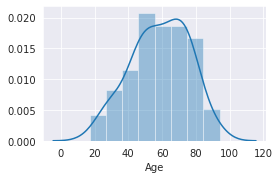

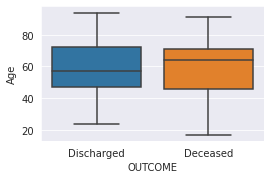

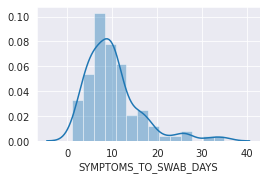

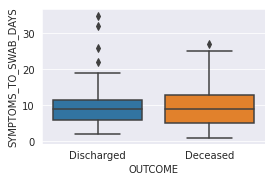

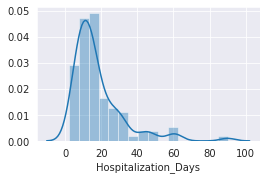

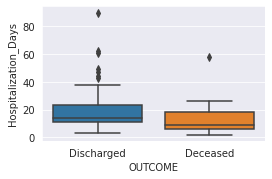

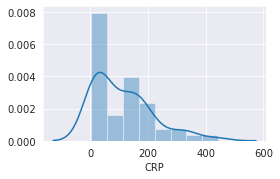

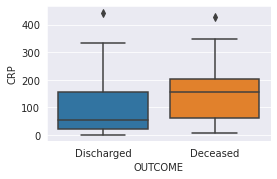

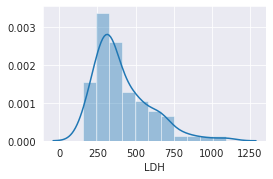

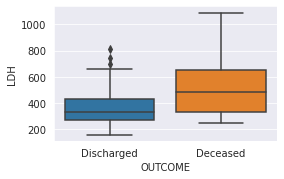

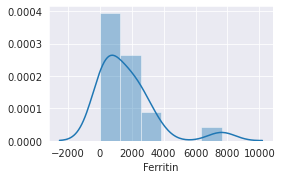

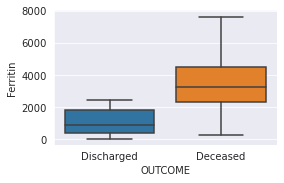

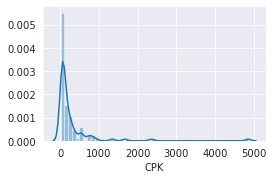

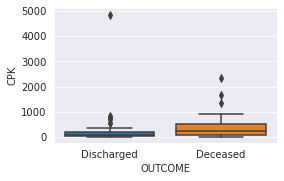

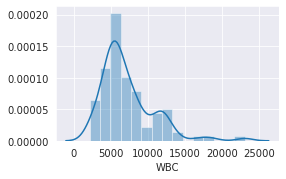

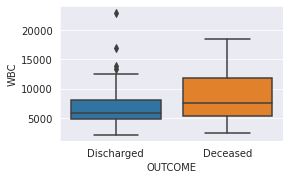

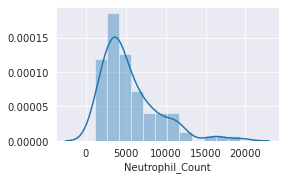

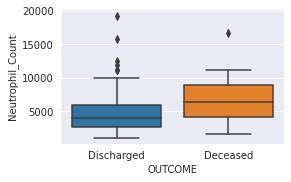

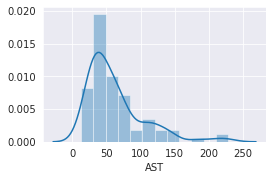

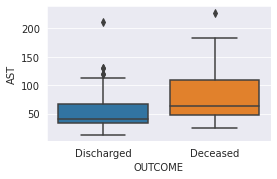

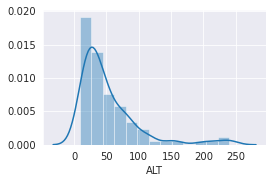

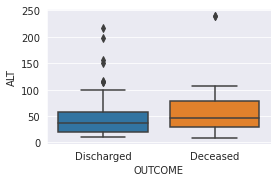

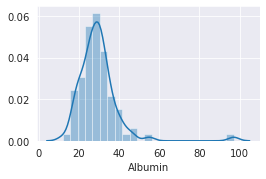

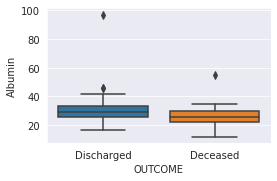

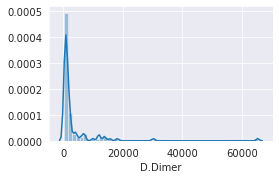

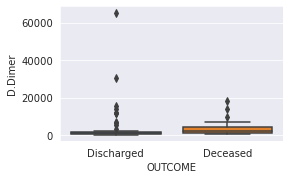

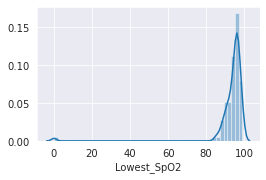

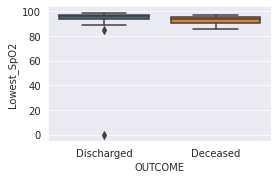

In [34]:
results = []

def upper_quantile(x):
    return x.quantile(.75)
    
def lower_quantile(x):
    return x.quantile(.25)

with pd.option_context('mode.use_inf_as_null', True):
    for col in continous_variables:
#         https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.anderson.html#scipy.stats.anderson
        values = df[col].dropna()
        _, ks_pvalue = sm.stats.diagnostic.kstest_normal(values, pvalmethod='approx')
        _, ad_pvalue = normal_ad(values)

        fig, ax = plt.subplots()
        sns.distplot(values, ax=ax)
        save_plot(fig, f"dist_univariate_{col}")
        plt.show()
        
        values_1 = df.loc[df[response] == 'Discharged', col].dropna()
        values_2 = df.loc[df[response] == 'Deceased', col].dropna()
        
        fig, ax = plt.subplots()
        sns.boxplot(x=response, y=col, ax=ax, data=df)
        save_plot(fig, f"boxplot_univariate_{col}")
        plt.show()
        
        result = df.groupby(response)[col].agg(['mean', 'std', upper_quantile, lower_quantile, "median"])
        _, tt_pvalue = ttest_ind(values_1, values_2)
        _, mw_pvalue = mannwhitneyu(values_1, values_2, alternative="two-sided")
        
        result["variable"] = col
        result["ad_pvalue"] = ad_pvalue
        result["ks_pvalue"] = ks_pvalue
        result["tt_pvalue"] = tt_pvalue
        result["mw_pvalue"] = mw_pvalue
        results.append(result)
df_results = pd.concat(results)

In [37]:
df_results.loc[df_results['tt_pvalue'] <= .1]

,mean,std,upper_quantile,lower_quantile,median,variable,ad_pvalue,ks_pvalue,tt_pvalue,mw_pvalue
OUTCOME,,,,,,,,,,
Deceased,13.320000,11.707263,18.00,6.00,9.0,Hospitalization_Days,2.272457e-15,6.479535e-11,0.065863,0.014103
Discharged,19.440000,14.977677,23.50,11.00,14.0,Hospitalization_Days,2.272457e-15,6.479535e-11,0.065863,0.014103
Deceased,162.120000,115.578011,204.00,63.00,154.0,CRP,2.614115e-08,7.429519e-06,0.003957,0.004157
Discharged,94.386667,93.512811,154.50,20.50,54.0,CRP,2.614115e-08,7.429519e-06,0.003957,0.004157
Deceased,517.875000,220.286042,652.75,333.25,482.0,LDH,3.811807e-07,1.972840e-05,0.000416,0.001860
Discharged,369.701493,148.250711,430.50,271.50,333.0,LDH,3.811807e-07,1.972840e-05,0.000416,0.001860
Deceased,3600.000000,3039.018811,4507.00,2346.50,3253.5,Ferritin,4.044384e-03,9.889562e-02,0.011270,0.099747
Discharged,1119.428571,861.894400,1809.50,388.25,863.0,Ferritin,4.044384e-03,9.889562e-02,0.011270,0.099747
Deceased,8195.416667,3781.052280,11785.00,5325.00,7510.0,WBC,2.912213e-08,2.770723e-06,0.097353,0.085655


In [35]:
df_results

,mean,std,upper_quantile,lower_quantile,median,variable,ad_pvalue,ks_pvalue,tt_pvalue,mw_pvalue
OUTCOME,,,,,,,,,,
Deceased,59.640000,17.978876,71.00,46.00,64.0,Age,1.626462e-01,3.350012e-01,0.742618,0.670114
Discharged,58.333333,16.914198,72.00,47.00,57.0,Age,1.626462e-01,3.350012e-01,0.742618,0.670114
Deceased,9.880000,6.527634,13.00,5.00,9.0,SYMPTOMS_TO_SWAB_DAYS,3.235462e-08,2.595532e-07,0.889330,0.761630
Discharged,10.080000,6.099978,11.50,6.00,9.0,SYMPTOMS_TO_SWAB_DAYS,3.235462e-08,2.595532e-07,0.889330,0.761630
Deceased,13.320000,11.707263,18.00,6.00,9.0,Hospitalization_Days,2.272457e-15,6.479535e-11,0.065863,0.014103
Discharged,19.440000,14.977677,23.50,11.00,14.0,Hospitalization_Days,2.272457e-15,6.479535e-11,0.065863,0.014103
Deceased,162.120000,115.578011,204.00,63.00,154.0,CRP,2.614115e-08,7.429519e-06,0.003957,0.004157
Discharged,94.386667,93.512811,154.50,20.50,54.0,CRP,2.614115e-08,7.429519e-06,0.003957,0.004157
Deceased,517.875000,220.286042,652.75,333.25,482.0,LDH,3.811807e-07,1.972840e-05,0.000416,0.001860


In [45]:
results = []
for col in binary_variables:
    ct = pd.crosstab(df[response], df[col])
    chi_square, p, dof, expected = chi2_contingency(ct)
    ct = ct.T
    ct.columns = ["DISCHARGED", "DECEASED"]
    ct["group"] = list(ct.index)
    ct["variable"] = col
    ct["pvalue"] = p
    ct.reset_index(inplace=True, drop=True)
    results.append(ct)

df_counts = pd.concat(results)

In [47]:
df_counts[df_counts['pvalue'] <= .1]

,DISCHARGED,DECEASED,group,variable,pvalue


In [43]:
df_counts

,DISCHARGED,DECEASED,group,variable,pvalue
0,22,54,No,viral_load,1.764248e-01
1,3,21,Yes,viral_load,1.764248e-01
0,7,26,F,Sex,7.126087e-01
1,18,49,M,Sex,7.126087e-01
0,12,47,No,Severe_Case,2.907460e-01
1,13,28,Yes,Severe_Case,2.907460e-01
0,23,69,No,REUMA,6.984617e-01
1,1,4,Yes,REUMA,6.984617e-01
2,0,2,yes,REUMA,6.984617e-01
0,22,67,No,PNEUMO,8.536040e-01
